In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from shapely.geometry import Point
import geopandas as gpd
pd.options.mode.chained_assignment = None

In [3]:
%qtconsole

### Table of Contents

* **NYC Taxi Data**
* **Ride Aggregator Model**
    * Spatial Pickup and Dropoff Probabilities
        * Generated Sets of Coordinates and Trajectory From Spatial Probabilities
	* Random Forrest Reggression
	* Percentage Time Difference for 2,3, and 4 riders
* **Efficiency Metrics**
	* Rides per Hour
	* Metrics Calculations
		* Metric per Hour
		* Metric per Weekday
		* Metric for Week
* **Results**
	* Astoria to Astoria
	* Astoria to Manhattan
	* Manhattan to Astoria
* **Summary**  <-------------------------------------- **Answers to Project Questions**
* **Functions**

In [14]:
a2a_df = pd.read_csv('data/my astoria to astoria.csv')
a2m_df = pd.read_csv('data/my astoria to manhattan.csv')
m2a_df = pd.read_csv('data/my manhattan to astoria.csv')

# NYC Taxi Data

The data collected from http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml was for June 2016 for the yellow cab and green cab service. The relevent data used in this analysis consists of:
* **weekday**: The day of the week from 0-6 where 0 is Monday and 6 is Sunday
* **hour**: The hour in the day from 0-23 whhere 0 is 12am and 23 is 11pm
* **pickup_on**: The logitudinal coordinate for passanger pick up location
* **pickup_lat**: The latitudinal coordinate for passanger pick up location
* **dropoff_on**: The logitudinal coordinate for passanger drop off location
* **dropoff_lat**: The latitudinal coordinate for passanger drop off location
* **trip_distance**: The total distance travelled on the the road
* **trip_duration**: The today duration of the trip (seconds)
* **trip_cost**: The trip cost excluding tips (dollars)

Bellow is a sample of the first 5 entress in the dataset:

In [26]:
a2m_df.head()

,weekday,hour,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,trip_distance,trip_duration,trip_cost
0,3.0,21.0,-73.931747,40.765339,-73.959785,40.761208,2.86,525.0,12.3
1,3.0,21.0,-73.921761,40.755619,-73.982079,40.773701,4.24,1008.0,17.3
2,3.0,21.0,-73.932167,40.759590,-73.971428,40.750622,3.01,803.0,14.3
3,3.0,21.0,-73.923149,40.755245,-73.978745,40.724388,5.62,1881.0,25.3
4,3.0,22.0,-73.930626,40.761154,-73.980583,40.741379,4.00,1205.0,18.3


This particular dataset consists of pickup points in Astoria corrsesponding to dropoff points in Manhattan. If we plot of the these points we get:

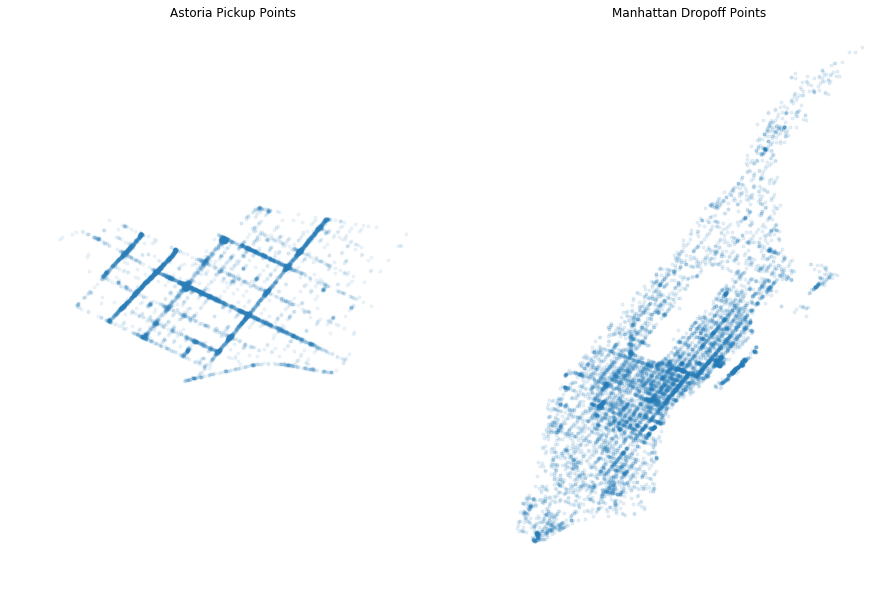

In [76]:
fig = plt.figure()
plt.subplot(121)
plt.plot(a2m_df.pickup_lon,a2m_df.pickup_lat,'.',alpha=.07)
plt.axis('off')
plt.axis('equal')
#size = fig.get_size_inches()*fig.dpi
plt.title('Astoria Pickup Points')

plt.subplot(122)
plt.plot(a2m_df.dropoff_lon,a2m_df.dropoff_lat,'.',alpha=.1)
plt.axis('off')
plt.title('Manhattan Dropoff Points')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2.5)

Which unsuprisingly follows the shape of manhattan and the street pattern in Astoria as plotted bellow:

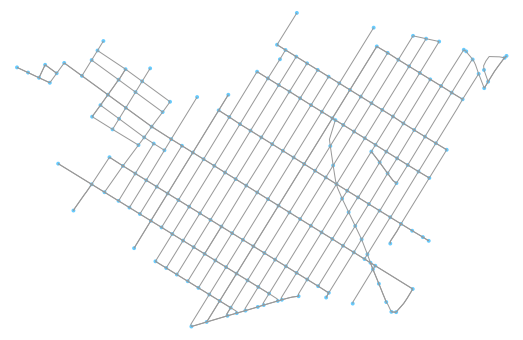

(<Figure size 890.282x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f843ba2e470>)

In [112]:
nyc = gpd.read_file('nynta_18d/nynta.shp')
nyc = nyc.to_crs({"init": "epsg:4326"})
astoria = nyc.loc[nyc['NTAName'] == 'Astoria']
astoria_shape = astoria.iloc[0].geometry
G = ox.graph_from_polygon(astoria_shape, network_type='drive')
ox.plot_graph(G)

# Ride Aggregator Model

There are quite a few ways to try to model combining riders from the NYC taxi network. The method I decided on is to set a predetermined pick location. From this pickup location 1 to 4 riders will board the cab and then the cab will proceed to the closest dropoff destination (measured by the strait distance between the 2 points, not by the road distance). After reaching that destination, the cab will again proceed to the next closest drop off destination.

Now for the same the pickup and dropoff points, a NYC taxi would simply start at the pickup point and end at the dropoff point per rider. In order to compare how our ride aggregator model does against the NYC taxi, we need to generate new pickup and dropoff points where the pickup is one location and the destinations can be at separate locations.

## Spatial Pickup and Dropoff Probabilities

First we generate new random sets of pickup and dropoff locations. We do that by finding the spatial probability for the pickup points and the dropoff points (**pickup_df** and **dropoff_df** respectively) from the data we have gathered from NYC.

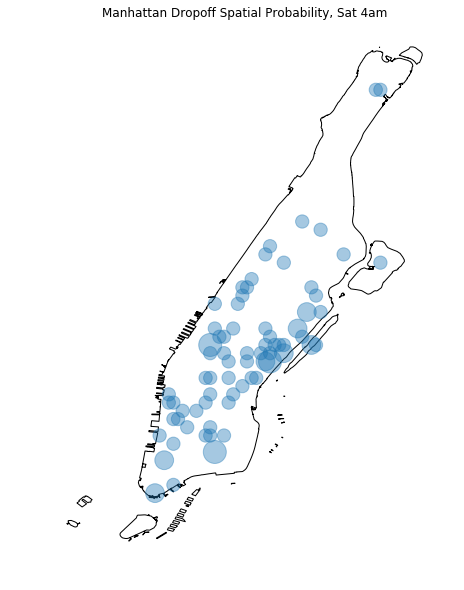

In [684]:
pickup_df, dropoff_df, pickup_num_hour = getspacialprob(a2m_df,50)

boroughs = gpd.read_file('Borough Boundaries/geo_export_0de71584-a1b1-48e3-adda-f106fd662625.shp')
manhattan = boroughs.loc[boroughs['boro_name'] == 'Manhattan']
manhattan_shape = manhattan.geometry[manhattan.index[0]]

fig, ax = plt.subplots()
manhattan.plot(ax=ax,color='white',edgecolor='black')
temp = dropoff_df.loc[dropoff_df.day == 5]
temp = temp.loc[temp.hour == 20]
temp = temp.loc[temp.prob != 0]
plt.scatter(temp.x,temp.y,s=temp.prob*15000,cmap='hot', alpha=.4) #,markersize=2) #,c=temp.prob,cmap='hot')
plt.axis('off')
plt.title('Manhattan Dropoff Spatial Probability, Sat 4am')
size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2.5)

Above I've plotted the likelihood of where in Manhattan a passenger will want to be dropped off. The biggest circle corresponds about a 3.5% chance of dropoff near the center of the circle, while the smallest circle corresponds to about a 1.2% chance of dropoff. These spatial probabilities can be improved by including more data from NYC.

In [15]:
data_df = a2a_df
pickup_df, dropoff_df, pickup_num_hour = getspacialprob(data_df,50)

#This for loop is because pickup_num_hour a total of pickups for a given weekday
#in a month. In order to get the average I must divid by the number of that particular
#weekday in the month. in June 2016 there where 5 Wednesday and Thursdays.
for i in range(7):
    if (i == 2) or (i == 3):
        nday = 5
    else:
        nday = 4
    pickup_num_hour[i,:] = pickup_num_hour[i,:]/nday

With our spatial probability for pickup and dropoff locations, we can generate random sets of rides (up to 4 rides) where we can compare a taxi service versus our ride aggregator model.

### Generated Sets of Coordinates and Trajectory From Spatial Probabilities

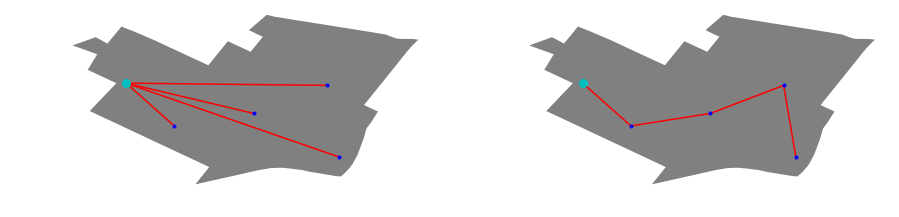

In [827]:
taxi_trips = pd.read_csv('taxi_trips for plot.cvs')
via_trips = pd.read_csv('via_trips for plot.cvs')

fig = plt.figure()
ax1 = plt.subplot(121)
astoria.plot(ax=ax1,color='grey')
for i in range(taxi_trips.shape[0]):
    plt.plot(taxi_trips[['pickup_lon','dropoff_lon']].iloc[i],taxi_trips[['pickup_lat','dropoff_lat']].iloc[i],'r')
for i in range(taxi_trips.shape[0]):
    plt.plot(taxi_trips[['pickup_lon','dropoff_lon']].iloc[i],taxi_trips[['pickup_lat','dropoff_lat']].iloc[i],'.b')
plt.plot(taxi_trips['pickup_lon'].iloc[0],taxi_trips['pickup_lat'].iloc[0],'.c',markersize=16)
#plt.title('Taxi: ' + '{:.4f}'.format(taxi_trips.disp_add.sum()))
plt.axis('off')
ax2 = plt.subplot(122)
astoria.plot(ax=ax2,color='grey')
plt.plot(via_trips[['pickup_lon','dropoff_lon']].iloc[0],via_trips[['pickup_lat','dropoff_lat']].iloc[0],'r')
plt.plot(via_trips['pickup_lon'].iloc[0],via_trips['pickup_lat'].iloc[0],'.c',markersize=16)
plt.plot(via_trips.dropoff_lon,via_trips.dropoff_lat,'r')
plt.plot(via_trips.dropoff_lon,via_trips.dropoff_lat,'.b')
#plt.title('Via: ' + '{:.4f}'.format(via_trips.disp_add.sum()))
plt.axis('off')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2.5)

Here I have plotted 4 riders going to different destinations within Astoria. The cyan dot is the originating pickup point and the blue dots are the dropoff points. The red lines correspond to path taken. On the left we have a traditional taxi model where the rider is taken directly to their destination and on the right we have our ride aggregator model. Recall, in this model we proceed to the closest dropoff destination and after reaching that destination, we will proceed to the next closest drop off destination.

The way we are going to access the efficiency of our ride aggregator service is to compare the total trip duration for different sets of our generated pickup and dropoff scenarios. For the same set of points, we'll predict the time it would take a taxi to complete each dropoffs and the time it would take our ride aggregator model to complete the dropoffs.

## Random Forrest Reggression 

We want to predict the time a takes for a cab to go from the pickup point to the dropoff point. Using the data aviable from NYC, I trained 3 random forrest models to predict trip time for 4 specific scenarios:
* Trip time for rides originating in Astoria going to Astoria
* Trip time for rides originating in Astoria going to Manhattan
* Trip time for rides originating in Manhattan going to Astoria
* Trip time for rides origination in Manhattan going to Manhattan

The features we trained the model on correspond to:

In [836]:
data_df[data_df.columns.values[0:6]].head()

,weekday,hour,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,3.0,21.0,-73.914192,40.763432,-73.908089,40.762878
1,3.0,22.0,-73.930504,40.761318,-73.920120,40.757538
2,3.0,22.0,-73.918938,40.759148,-73.913719,40.762672
3,3.0,22.0,-73.931488,40.765308,-73.922531,40.763905
4,3.0,22.0,-73.925171,40.761921,-73.912224,40.767384


The target will be **trip_duration** which is in seconds.

In [840]:
data_df[data_df.columns.values[7:8]].head()

,trip_duration
0,172.0
1,235.0
2,117.0
3,167.0
4,298.0


### ******** Please refer to Jupyter notebook titled _Trip Duration Models_ for the code and data used to train the models ****

In [17]:
rf = joblib.load('astoria to astoria.joblib')
scaler = joblib.load('astoria to astoria scaler.joblib')

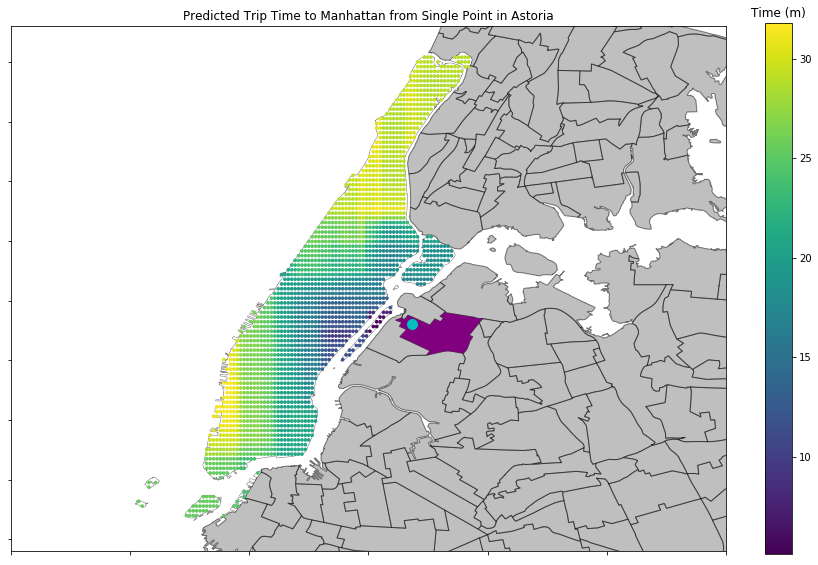

In [15]:
inman_xy = pd.read_csv('pred_tomanhattan.csv')
fig, ax = plt.subplots(figsize=[7,7])
nyc.plot(ax=ax, color="grey", edgecolor="black", alpha=.5);
manhattan.plot(ax=ax,color='white')
plt.scatter(inman_xy.x, inman_xy.y,c=inman_xy.z/60, s=7)
astoria.plot(ax=ax,color='purple')
plt.plot(a2m_df.pickup_lon[0],a2m_df.pickup_lat[0],'.c',markersize=20)

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.ylim([40.67,40.89])
plt.xlim([-74.1,-73.8])
plt.title('Predicted Trip Time to Manhattan from Single Point in Astoria')
clb = plt.colorbar(fraction=.034)
clb.ax.set_title('Time (m)')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

Plotted above is what the algorithm predicts the time it will take for a trip from one specific location in Astoria (cyan dot) to anywhere in Manhattan. Using this algorithm we can predict and compare how long it will take for a NYC taxi to complete a set of rides verses how long it would take a ride aggregating service like Via.

## Percentage Time Difference for 2,3, and 4 riders

In [37]:
columns = data_df.columns[0:6].tolist()
taxi_day_hour_time, via_day_hour_time = timepertrip(pickup_df,dropoff_df,10,columns)

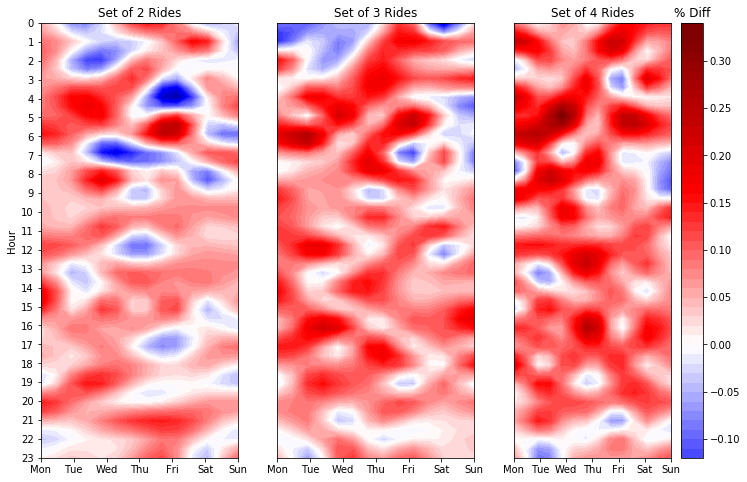

In [38]:
fig, ax = plt.subplots(1,3)

temp = np.divide((taxi_day_hour_time - via_day_hour_time), taxi_day_hour_time)
maxmin = np.abs(np.array([temp.max(),temp.min()]))
absmax = maxmin.max()

for i in range(3):
    #plt.subplot(1,3,i+1)
    plt.sca(ax[i])
    dif_per = temp[i,:,:]
    plt.contourf(scipy.ndimage.zoom(dif_per.T,2),50,cmap='seismic',vmax=absmax, vmin=-absmax)
    #ax[i].xaxis.tick_top()
    ax[i].invert_yaxis()
    plt.xticks(np.linspace(0,13,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    plt.title('Set of ' + str(i+2) + ' Rides')
    
    if i == 0:
        plt.yticks(np.linspace(0,47,24),np.arange(0,24,1))
        plt.ylabel('Hour')
    else:
        plt.yticks([])
    
#plt.title('Percentage Time Diffence (Taxi-Via)/Via')
clb = plt.colorbar()
clb.ax.set_title('% Diff')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

In the plots above we have the percentage time difference: $$\frac{T_{Taxi} - T_{Via}}{T_{Taxi}}$$ for 3 different number of rides originating in Astoria and ending in Astoria. The first plot is for 2 riders, the second is for 3 riders, and the third is for 4 riders at each hour in a week.

We see that a ride aggregator service would outperform a normal taxi service for the 3 scenarios for the most part. It seem the normal taxi service would do better for a few pockets of blue past 12am. This might arise from the diminishing of traffic at these hours and therefore the time performance for the taxi increases.

# Efficiency Metrics

From the percentage time difference plots it seems like the ride aggregtor service performs better more often than the taxi service for the 3 rides scenarios. We now calculate the the rides per hour from our data set in order to establish the most efficient our ride aggregator model would perform.

## Rides per Hour

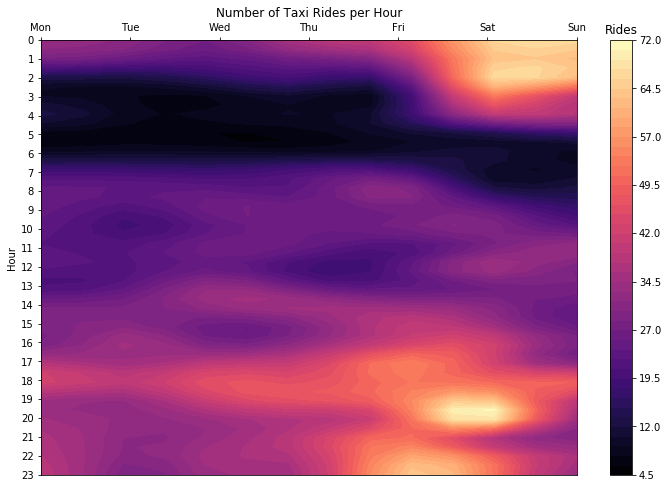

In [39]:
fig, ax = plt.subplots()
plt.contourf(scipy.ndimage.zoom(pickup_num_hour.T,2),50,cmap='magma')
ax.xaxis.tick_top()
ax.invert_yaxis()
plt.xticks(np.linspace(0,13,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.yticks(np.linspace(0,47,24),np.arange(0,24,1))
plt.ylabel('Hour')
plt.title('Number of Taxi Rides per Hour')
clb = plt.colorbar()
clb.ax.set_title('Rides')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

This is the rate of rides per hour in a giving week. In the above plot we can clearly see certain patterns in the number of rides per hour in a week. We see an increased at around 7am, peaking around 7pm, Monday through Friday which can be attributed to people commuting to work and home. We also see increase ridership at night and into the morning as we approach the weekend.

## Metrics Calculations

In [40]:
eff, eff_day, eff_hour = getmetric(taxi_day_hour_time,via_day_hour_time,pickup_num_hour)

Using the number of rides per hour calculation plotted above, we take the rides per hour for that particular hour, find which of the 3 ride scenarios (2 riders, 3 riders, or 4 riders) has the best percentage time difference and use that scenario to calculate the total time for all the rides in that hour. We can then compare it to the total time  it would take the taxi for the same hour.

### Metric per Hour

$$ \frac{T_{TaxiHour} - T_{ViaHour}}{T_{TaxiHour}} $$

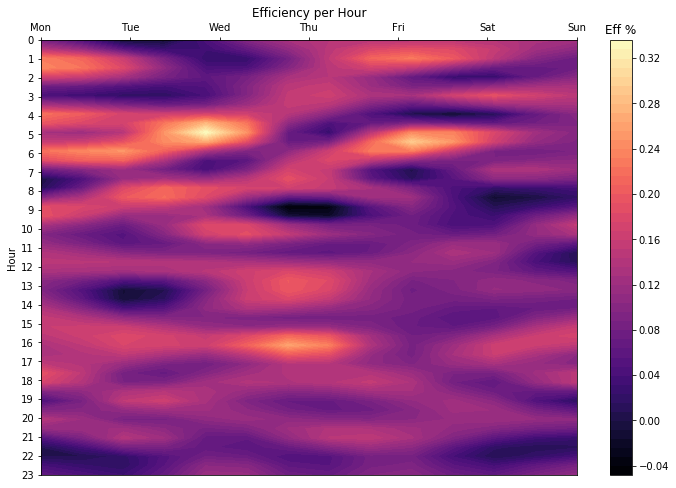

In [41]:
fig, ax = plt.subplots()
plt.contourf(scipy.ndimage.zoom(eff_hour.T,2),50,cmap='magma')
plt.xticks(np.linspace(0,13,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.yticks(np.linspace(0,47,24),np.arange(0,24,1))
plt.ylabel('Hour')
plt.title('Efficiency per Hour')
ax.xaxis.tick_top()
ax.invert_yaxis()
clb = plt.colorbar()
clb.ax.set_title('Eff %')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

### Metric per Weekday

$$ \frac{T_{TaxiDay} - T_{ViaDay}}{T_{TaxiDay}} $$


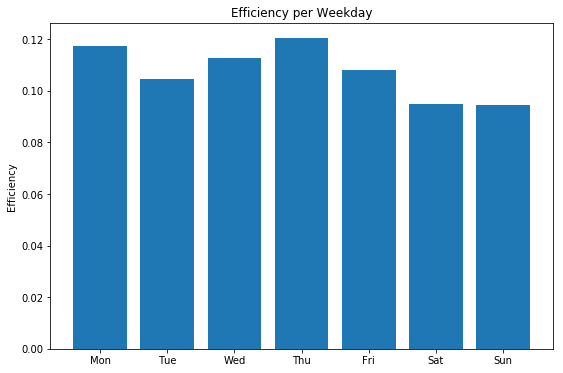

In [42]:
fig = plt.figure()
plt.plot()
plt.bar(range(7),eff_day)
plt.xticks(np.linspace(0,6,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Efficiency')
plt.title('Efficiency per Weekday')


size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*1.5)

### Metric for Week

$$ \frac{T_{TaxiWeek} - T_{ViaWeek}}{T_{TaxiWeek}} $$

In [43]:
print('Efficiency: {:.2f}'.format(eff))

Efficiency: 0.11


The efficieny shows how much better or worse we can expect to do using our aggregator model. The efficiency value has a maximum of 1 corresponding to a perfect, 0 trip time for a ride. While attaining a 1 is impossible under our model, a positive increase signifies a smaller trip completion time when compared to the taxi trip completion time. The minimum value can go to $-\infty$ corresponding to a longer and longer trip duration relative to the taxi trip duration.

# Results

## Astoria to Astoria

In [25]:
data_df = pd.read_csv('data/my astoria to astoria.csv')
pickup_df, dropoff_df, pickup_num_hour = getspacialprob(data_df,50)

#This for loop is because pickup_num_hour a total of pickups for a given weekday
#in a month. In order to get the average I must divid by the number of that particular
#weekday in the month. in June 2016 there where 5 Wednesday and Thursdays.
for i in range(7):
    if (i == 2) or (i == 3):
        nday = 5
    else:
        nday = 4
    pickup_num_hour[i,:] = pickup_num_hour[i,:]/nday

In [26]:
rf1 = joblib.load('models/astoria to astoria.joblib')
scaler1 = joblib.load('models/astoria to astoria scaler.joblib')
rf2 = rf1
scaler2 = scaler1

In [27]:
columns = data_df.columns[0:6].tolist()
taxi_day_hour_time, via_day_hour_time = timepertrip(pickup_df,dropoff_df,50,columns)

In [28]:
eff, eff_day, eff_hour = getmetric(taxi_day_hour_time,via_day_hour_time,pickup_num_hour)

Total Efficiency Metric: 0.085, ranges from -inf to 1.


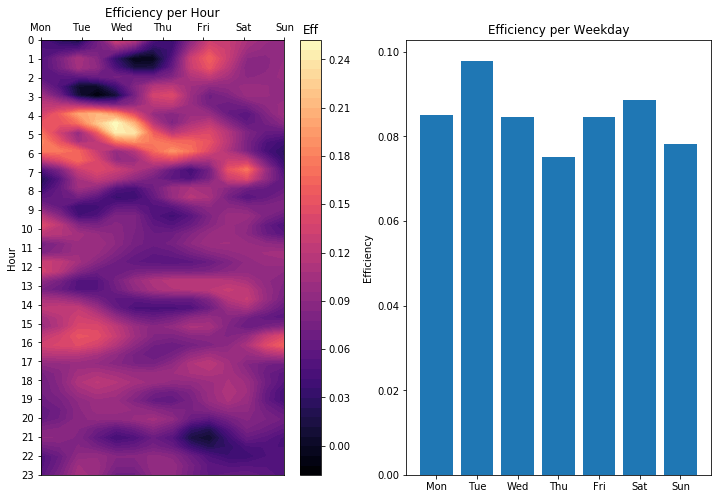

In [29]:
fig = plt.figure()
ax = plt.subplot(121)

plt.contourf(scipy.ndimage.zoom(eff_hour.T,2),50,cmap='magma')
plt.xticks(np.linspace(0,13,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.yticks(np.linspace(0,47,24),np.arange(0,24,1))
plt.ylabel('Hour')
plt.title('Efficiency per Hour')
ax.xaxis.tick_top()
ax.invert_yaxis()
clb = plt.colorbar()
clb.ax.set_title('Eff')

#size = fig.get_size_inches()*fig.dpi
#fig.set_size_inches((size/fig.dpi)*2)

#plt.contourf(eff_hour.T,50)
plt.subplot(122)
plt.bar(range(7),eff_day)
plt.xticks(np.linspace(0,6,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Efficiency')
plt.title('Efficiency per Weekday')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

print('Total Efficiency Metric: ' + '{:0.3f}'.format(eff) + ', ranges from -inf to 1.' )

## Astoria to Manhattan

In [24]:
data_df = pd.read_csv('data/my astoria to manhattan.csv')
pickup_df, dropoff_df, pickup_num_hour = getspacialprob(data_df,50)

#This for loop is because pickup_num_hour a total of pickups for a given weekday
#in a month. In order to get the average I must divid by the number of that particular
#weekday in the month. in June 2016 there where 5 Wednesday and Thursdays.
for i in range(7):
    if (i == 2) or (i == 3):
        nday = 5
    else:
        nday = 4
    pickup_num_hour[i,:] = pickup_num_hour[i,:]/nday

In [27]:
rf1 = joblib.load('models/astoria to manhattan.joblib')
scaler1 = joblib.load('models/astoria to manhattan scaler.joblib')
rf2 = joblib.load('models/manhattan to manhattan.joblib')
scaler2 = joblib.load('models/manhattan to manhattan scaler.joblib')

In [28]:
columns = data_df.columns[0:6].tolist()
taxi_day_hour_time, via_day_hour_time = timepertrip(pickup_df,dropoff_df,10,columns)

In [29]:
eff, eff_day, eff_hour = getmetric(taxi_day_hour_time,via_day_hour_time,pickup_num_hour)

Total Efficiency Metric: 0.394, ranges from -inf to 1.


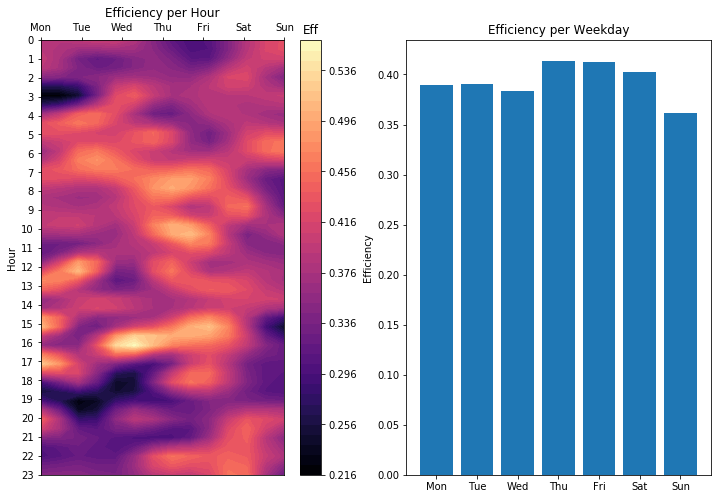

In [30]:
fig = plt.figure()
ax = plt.subplot(121)

plt.contourf(scipy.ndimage.zoom(eff_hour.T,2),50,cmap='magma')
plt.xticks(np.linspace(0,13,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.yticks(np.linspace(0,47,24),np.arange(0,24,1))
plt.ylabel('Hour')
plt.title('Efficiency per Hour')
ax.xaxis.tick_top()
ax.invert_yaxis()
clb = plt.colorbar()
clb.ax.set_title('Eff')

#size = fig.get_size_inches()*fig.dpi
#fig.set_size_inches((size/fig.dpi)*2)

#plt.contourf(eff_hour.T,50)
plt.subplot(122)
plt.bar(range(7),eff_day)
plt.xticks(np.linspace(0,6,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Efficiency')
plt.title('Efficiency per Weekday')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

print('Total Efficiency Metric: ' + '{:0.3f}'.format(eff) + ', ranges from -inf to 1.' )

## Manhattan to Astoria

In [39]:
data_df = pd.read_csv('data/my manhattan to astoria.csv')
pickup_df, dropoff_df, pickup_num_hour = getspacialprob(data_df,50)

#This for loop is because pickup_num_hour a total of pickups for a given weekday
#in a month. In order to get the average I must divid by the number of that particular
#weekday in the month. in June 2016 there where 5 Wednesday and Thursdays.
for i in range(7):
    if (i == 2) or (i == 3):
        nday = 5
    else:
        nday = 4
    pickup_num_hour[i,:] = pickup_num_hour[i,:]/nday

In [21]:
rf1 = joblib.load('models/manhattan to astoria.joblib')
scaler1 = joblib.load('models/manhattan to astoria scaler.joblib')
rf2 = joblib.load('models/astoria to astoria.joblib')
scaler2 = joblib.load('models/astoria to astoria scaler.joblib')

In [22]:
columns = data_df.columns[0:6].tolist()
taxi_day_hour_time, via_day_hour_time = timepertrip(pickup_df,dropoff_df,10,columns)

In [23]:
eff, eff_day, eff_hour = getmetric(taxi_day_hour_time,via_day_hour_time,pickup_num_hour)

Total Efficiency Metric: 0.619, ranges from -inf to 1.


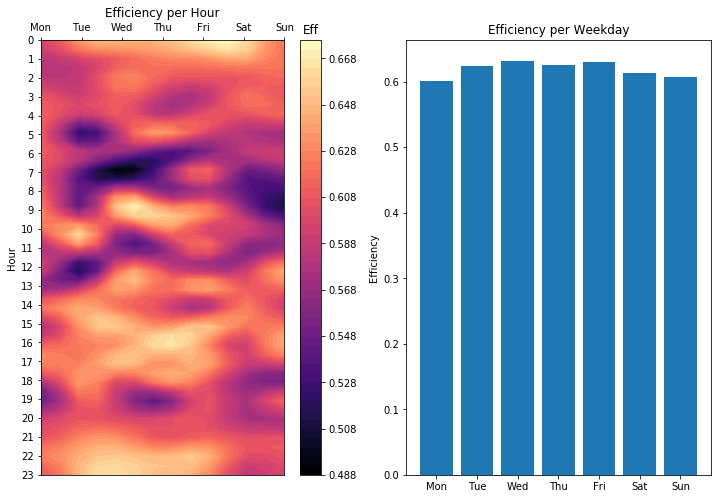

In [24]:
fig = plt.figure()
ax = plt.subplot(121)

plt.contourf(scipy.ndimage.zoom(eff_hour.T,2),50,cmap='magma')
plt.xticks(np.linspace(0,13,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.yticks(np.linspace(0,47,24),np.arange(0,24,1))
plt.ylabel('Hour')
plt.title('Efficiency per Hour')
ax.xaxis.tick_top()
ax.invert_yaxis()
clb = plt.colorbar()
clb.ax.set_title('Eff')

#size = fig.get_size_inches()*fig.dpi
#fig.set_size_inches((size/fig.dpi)*2)

#plt.contourf(eff_hour.T,50)
plt.subplot(122)
plt.bar(range(7),eff_day)
plt.xticks(np.linspace(0,6,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Efficiency')
plt.title('Efficiency per Weekday')

size = fig.get_size_inches()*fig.dpi
fig.set_size_inches((size/fig.dpi)*2)

print('Total Efficiency Metric: ' + '{:0.3f}'.format(eff) + ', ranges from -inf to 1.' )

---

---

# Summary

1. The way I chose to model a ride sharing service was with a specific pickup location where the riders would get on and then proceed to their dropoff destinations. The model would prioritize dropoff by distance from the pickup location and then by each subsequent dropoff point. For simplicity, I used the straight line distance to generate the dropoff priority (using my trip time prediction model to prioritize by time of trip would improve this model). (See the Generated Sets of Coordinates and Trajectory From Spatial Probabilities section above)

  The model will then use the optimum rider aggregation to complete rides the fasts to calculate the potential efficiency metric of the service. This means, hypothetically, if on Wednesday from 2-3pm the most efficient ride aggregation is having 3 people picked up at the same location and then taken to their dropoff points, then it will calculate how much time it will take to complete the rides in that hour, allowing only for a maximum of 3 people per ride, and then comparing that to the normal taxi service which would provide pickup and dropoff per customer.
  
  This model neglects wait time for all riders to arrive at the pickup location and for the car/taxi to arrive and similarly the dataset for taxi rides does not include how long it takes to hail a taxi.


2. I would provide the service between Astoria and Manhattan and between Manhattan and Astoria. According to my analysis we could potentially complete number of dropoffs 40% faster from Astoria to Manhattan and up to 60% faster from Manhattan to Astoria when compared to the NYC taxi service. For rides within Astoria, my model indicates a potential 10% faster completion when compared to the same taxi rides. Considering the average time for a taxi to complete one ride in Astoria is about 5 minutes, it’s not a considerable gain in efficiency. Furthermore, my model for the trip time estimates within Astoria is the poorest performing of my models. I think because of the smaller region size, and the shorted trip times, fluctuations in the data set have quite a big impact. I think training this model with more data should help in this regard and trying to add more features like traffic density data. As it stands right now, I would not suggest having the service operated for rides within Astoria without refining the model some more.


3. For rides within Astoria, the predicted times that the rider aggregating service would be most efficient would be in the morning between 4am to 8am, Monday through Friday, peaking on Wednesday. It predicts a potential dropoff completion of about 15-20% faster than the NYC taxi service (see Efficiency per Hour plot above for rides from Astoria to Astoria in the Results section). For rides from Astoria to Manhattan the most efficient hours of operations would be between 4am to 6pm Monday through Friday where we get a dropoff completion of about 30-60% faster when compared to the NYC taxi services (see Efficiency per Hour plot above for rides from Astoria to Manhattan in the Results section). For rides from Manhattan to Astoria, any time of day we can get a minimum efficiency of 50% (see Efficiency per Hour plot above for rides from Manhattan to Astoria in the Results section). I would operate the service from Astoria to Manhattan and from Manhattan to Astoria 24-7 and have the service operate in the mornings during the work week within Astoria.

4. I would plot the distributions of the efficiency metric contained within the specific zone and I would also plot the distribution of the efficiency metric for the rest of the city. I would then calculate the mean $\overline{x}$, the standard error $\sigma_{\overline{x}} = \sigma/\sqrt{n}$ for both areas (zone and rest of city) where $n$ would be the number of efficiency metrics within the given area and $\sigma$ is the standard deviation for the respective distribution. This would give us:

  $$ \overline{x}_{zone} \pm \sigma_{\overline{x}_{zone}}, \quad \overline{x}_{city} \pm \sigma_{\overline{x}_{city}}$$

  We can now find the difference and propagate our error using standard error propagation:

  $$F = F(x_1,y_1), \quad \delta F = \sqrt{\big(\frac{\partial F}{\partial x_1} \delta x_1 \big)^2 + \big(\frac{\partial F}{\partial x_2} \delta x_2 \big)^2 }$$

  which give us

  $$ d = \overline{x}_{city} - \overline{x}_{zone}, \quad \delta d = \sqrt{\sigma_{\overline{x}_{city}}^2 + \sigma_{\overline{x}_{zone}}^2}$$

  then $$\frac{d}{\delta d}$$
  
  will give us a measure of the difference relative to their standard error. In order to determine why it's more efficient, I would divide the city up by some number of zones. I woult then calculate the measure of the difference for each zone ($\frac{d_i}{\delta d_i}$). Then using datapoints pertaining to each zone (i.e. number of pickups, number of dropoff, population, etc) I would try to see if there is a correlation between these datapoints in each zone to how their efficiency compares to the overall city.


5. For both distributions, I would try to identify certain features in the distribution such as different peaks in the distribution (i.e. the data has a peak at low prices but also a peak at high prices from fix airport pricing). For the different peaks we can calculate a standard deviation to get a measure of the variation around the peak. We can take the Fourier transform of the distribution to identify any underlying periodicity in pricing. These would be different attributes of the distributions that we could compare between cities.

 In order to test whether differences are explained by distance and duration, we can see if the differences persist after calculating the distribution for price/distance or price/duration. For example, if one city has more trips with higher prices than another city and calculating the price/distance distribution for both cities gives similar distributions then we can attribute the higher prices peak in one city to further trips in that city (maybe the city is more spread out than the other hence further trips in that city).


---

# Functions

In [17]:
def timepertrip(pickup_df,dropoff_df,datapoints,columns):

    columns.append('disp_add')

    #eff_day_hour_price = np.zeros([3,7,24])
    #eff_day_hour_time = np.zeros([3,7,24])

    taxi_day_hour_time = np.zeros([3,7,24])
    via_day_hour_time = np.zeros([3,7,24])

    for riders in range(2,5): 
        for day in range(7):
            for hour in range(24):
                print('Riders: ' + str(riders) + '; Day: ' + str(day+1) + '; Hour: ' + str(hour+1),end='\r')
        
                taxi_trips, via_trips = rand_trips_set(pickup_df,dropoff_df,riders,datapoints,columns,day,hour)

                taxi_data = taxi_trips.drop('disp_add',axis=1)
                via_data = via_trips.drop('disp_add',axis=1)

                via_data = via_data.reset_index().drop('index',axis=1)
                via1 = via_data.iloc[np.arange(0,datapoints*riders,riders)]
                via2 = via_data.drop(via1.index.values,axis=0)              
                #print(via1.index.values)
                #print(via1.columns.values)
                #print(via1.shape)
                #print(scaler1.transform(via1))
                
                
                via1_data_scaled = pd.DataFrame(scaler1.transform(via1),index=via1.index.values,columns=via1.columns.values)
                via2_data_scaled = pd.DataFrame(scaler2.transform(via2),index=via2.index.values,columns=via2.columns.values)
                
                taxi_data_scaled = pd.DataFrame(scaler1.transform(taxi_data),index=taxi_data.index.values,columns=taxi_data.columns.values)
                #via_data_scaled = pd.DataFrame(scaler.transform(via_data),index=via_data.index.values,columns=via_data.columns.values)

                taxi_predict = rf1.predict(taxi_data_scaled)
                
                via1_predict = rf1.predict(via1_data_scaled)
                via2_predict = rf2.predict(via2_data_scaled)

                ind = np.arange(via_data.shape[0])
                ind1 = range(0,datapoints*riders,riders)
                ind2 = [i for i in ind if i not in ind1]
                
                via_predict = np.zeros(via_data.shape[0])
                via_predict[ind1] = via1_predict
                via_predict[ind2] = via2_predict
                #via_predict[ind1] = np.squeeze(via1_predict[:,0])
                #via_predict[ind2] = np.squeeze(via2_predict[:,0])              
                
                stats_df = getstats(taxi_predict,via_predict,riders,datapoints)

                #eff_day_hour_price[riders-2,day,hour] = (stats_df.taxi_tot_price.mean() - stats_df.via_tot_price.mean())/stats_df.taxi_tot_price.mean()
                #eff_day_hour_time[riders-2,day,hour] = (stats_df.taxi_tot_time.mean() - stats_df.via_tot_time.mean())/stats_df.taxi_tot_time.mean()
            
                taxi_day_hour_time[riders-2,day,hour] = stats_df.taxi_tot_time.mean()
                via_day_hour_time[riders-2,day,hour] = stats_df.via_tot_time.mean()
                
    return taxi_day_hour_time, via_day_hour_time

In [18]:
def getmetric(taxi_day_hour_time,via_day_hour_time,pickup_num_hour):

    eff_hour_avg = np.zeros([7,24])
    eff_day_avg = np.zeros(7)
    eff = 0

    dif_tot_week = 0
    taxt_tot_week = 0

    rider_time = taxi_day_hour_time-via_day_hour_time

    for i in range(7):
        dif_tot_day = 0
        taxt_tot_day = 0
    
        for j in range(24):
        
            best_ride = np.argmax(rider_time[:,i,j])
            num = pickup_num_hour[i,j]
            div = int(num/(best_ride+2))
            mod = int(num%(best_ride+2))
            dif = 0
            taxt = 0
        
            if mod == 2:
                dif = taxi_day_hour_time[0,i,j] - via_day_hour_time[0,i,j]
                taxt = taxi_day_hour_time[0,i,j]
            elif mod == 3:
                dif = taxi_day_hour_time[1,i,j] - via_day_hour_time[1,i,j]
                taxt = taxi_day_hour_time[1,i,j]
        
            dif_tot = div*(taxi_day_hour_time[best_ride,i,j] - via_day_hour_time[best_ride,i,j]) + dif
            taxt_tot = div*taxi_day_hour_time[best_ride,i,j] + taxt
        
            eff_hour_avg[i,j] = dif_tot/taxt_tot
        
            dif_tot_day = dif_tot_day + dif_tot
            taxt_tot_day = taxt_tot_day + taxt_tot
    
        eff_day_avg[i] = dif_tot_day/taxt_tot_day
    
        dif_tot_week = dif_tot_week + dif_tot_day
        taxt_tot_week = taxt_tot_week + taxt_tot_day

    eff = dif_tot_week/taxt_tot_week
    
    return eff, eff_day_avg, eff_hour_avg

In [19]:
def getspacialprob(data_df,px):
    pickup_df = pd.DataFrame()
    dropoff_df = pd.DataFrame()
    pickup_num_hour = np.zeros([7,24])  
    for day in range(7):
        temp0 = data_df.loc[data_df.weekday==day]
        for hour in range(24):
            temp1 = temp0.loc[temp0.hour==hour]
            pickup_num_hour[day,hour] = temp1.shape[0]
            z,x,y = np.histogram2d(temp1.dropoff_lon,temp1.dropoff_lat,bins=[px,px])
            x_mesh, y_mesh = np.meshgrid(np.linspace(x.min(),x.max(),px+1),np.linspace(y.min(),y.max(),px+1))
            z = z.ravel()/z.sum()
            x = x_mesh[0:-1,0:-1].T.ravel()
            y = y_mesh[0:-1,0:-1].T.ravel()       
            day_array = np.repeat(day,z.shape[0])
            hour_array = np.repeat(hour,z.shape[0])
            dropoff_df = dropoff_df.append(pd.DataFrame(np.array([day_array,hour_array,z,x,y]).T,columns=['day','hour','prob','x','y']))
            z,x,y = np.histogram2d(temp1.pickup_lon,temp1.pickup_lat,bins=[px,px])
            x_mesh, y_mesh = np.meshgrid(np.linspace(x.min(),x.max(),px+1),np.linspace(y.min(),y.max(),px+1))
            z = z.ravel()/z.sum()
            x = x_mesh[0:-1,0:-1].T.ravel()
            y = y_mesh[0:-1,0:-1].T.ravel()
            pickup_df = pickup_df.append(pd.DataFrame(np.array([day_array,hour_array,z,x,y]).T,columns=['day','hour','prob','x','y']))

    return pickup_df,dropoff_df,pickup_num_hour

In [20]:
def genrantrip(pickup_df,dropoff_df,n,columns,day=-1,hour=-1):

    if day == -1:
        day = np.random.choice(np.arange(7),1)[0]
    if hour == -1:
        hour = np.random.choice(np.arange(24),1)[0]
        
    pickup_prob = pickup_df.loc[pickup_df.day == day]
    pickup_prob = pickup_prob.loc[pickup_prob.hour == hour]
    pickup_prob = pickup_prob.loc[pickup_prob.prob != 0]
    dropoff_prob = dropoff_df.loc[dropoff_df.day == day]
    dropoff_prob = dropoff_prob.loc[dropoff_prob.hour == hour]
    dropoff_prob = dropoff_prob.loc[dropoff_prob.prob != 0]
    
    pickup_points = pickup_df.iloc[np.random.choice(pickup_prob.index.tolist(),1,pickup_prob.prob.tolist())]
    pickup_points = pd.DataFrame(np.repeat(pickup_points.values,n,axis=0),columns=pickup_points.columns)
    
    #print(np.random.choice(dropoff_prob.index.tolist(),n,dropoff_prob.prob.tolist()))
    
    dropoff_points = dropoff_df.iloc[np.random.choice(dropoff_prob.index.tolist(),n,dropoff_prob.prob.tolist())]

    disp = np.sqrt((pickup_points.x.values - dropoff_points.x.values)**2 + (pickup_points.y.values - dropoff_points.y.values)**2)
    
    day = np.repeat(day,n)
    hour = np.repeat(hour,n)
        
    trips = pd.DataFrame(np.array([day,hour,pickup_points.x.values,pickup_points.y.values,dropoff_points.x.values,dropoff_points.y.values,disp]).T,columns=columns)
    #disp = np.sqrt((newdata.pickup_lon - newdata.dropoff_lon)**2 + (newdata.pickup_lat - newdata.dropoff_lat)**2)
    return trips

In [21]:
def triporder (trips,firstride=False):
    end = len(trips.index.values)

    trips.index = range(end)
    

    #loc0 = np.sqrt((trips.pickup_lon.iloc[0] - trips.dropoff_lon.iloc[0])**2 + (trips.pickup_lat.iloc[0] - trips.dropoff_lat.iloc[0])**2)
    #disp = np.sqrt((trips.pickup_lon - trips.dropoff_lon)**2 + (trips.pickup_lat - trips.dropoff_lat)**2)
    
    #trips['disp_add'] = disp # np.zeros(end)
    
    ind = (trips.disp_add.loc[trips.disp_add == trips.disp_add.min()]).index.values[0]
    
    if (firstride == True):
        ind = 0
            
    x0 = trips.dropoff_lon.iloc[ind]
    y0 = trips.dropoff_lat.iloc[ind]

    #new_dropoff_points = pd.DataFrame()
    #new_dropoff_points = trips.loc[ trips.index == 0] #trips.iloc[0:1].copy()
    new_dropoff_points = trips.loc[ trips.index == ind] #trips.iloc[0:1].copy()
    new_dropoff_points.disp_add.loc[ind] = trips.disp_add[ind]
    trips = trips.drop(ind,axis=0)
    prevind = 0
    
    for i in range(end-1):
        x = trips.dropoff_lon
        y = trips.dropoff_lat
        disp = np.sqrt((x-x0)**2 + (y-y0)**2)
        ind = (disp.loc[disp == disp.min()]).index.values[0]
        new_dropoff_points = new_dropoff_points.append(trips.loc[ind])
        new_dropoff_points.disp_add.loc[ind] = disp[ind]
        new_dropoff_points.pickup_lon.loc[ind] = x0
        new_dropoff_points.pickup_lat.loc[ind] = y0
        x0 = trips.dropoff_lon.loc[ind]
        y0 = trips.dropoff_lat.loc[ind]
        trips = trips.drop(ind,axis=0)

    return new_dropoff_points

In [22]:
def rand_trips_set(pickup_df,dropoff_df,riders,n,columns,day=-1,hour=-1):
    
    taxi_trips = pd.DataFrame()
    via_trips = pd.DataFrame()
    
    for i in range(n):
        temp_taxi_trips = genrantrip(pickup_df,dropoff_df,riders,columns,day,hour)
        via_trips = via_trips.append(triporder(temp_taxi_trips))
        taxi_trips = taxi_trips.append(temp_taxi_trips)
    
    #newcol = columns.tolist()
    #newcol.append('disp_add')
    
    return taxi_trips[columns], via_trips[columns]

In [23]:
def getstats(taxi_predict,via_predict,riders,datapoints):

    #statcolumns = ['taxi_price_time','taxi_tot_time','taxi_tot_price','via_tot_time','via_tot_price']
    statcolumns = ['taxi_tot_time','via_tot_time']
    stats_df = pd.DataFrame(columns=statcolumns)

    for i in range(datapoints):
        myrange = range((i*riders),(i+1)*riders)
        #t_temp = taxi_predict[myrange,:]
        #v_temp = via_predict[myrange,0]
        
        t_temp = taxi_predict[myrange]
        v_temp = via_predict[myrange]
    
        taxi_tot_time = (np.sum(t_temp))
        #taxi_tot_time = (np.sum(t_temp[:,0]))
        #taxi_tot_price = (np.sum(t_temp[:,1]))
        #avg = np.mean(t_temp[:,1]/t_temp[:,0])
        via_tot_time = (np.sum(v_temp))
        #via_tot_price = (np.sum(v_temp)*avg)
        
        temp = pd.DataFrame(np.array([taxi_tot_time,via_tot_time]).reshape([1,2]),columns=statcolumns)
        #temp = pd.DataFrame(np.array([avg,taxi_tot_time,taxi_tot_price,via_tot_time,via_tot_price]).reshape([1,5]),columns=statcolumns)
        stats_df = stats_df.append(temp)
    
    return stats_df